In [20]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        pass
        #print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [21]:
!pip install -U git+https://github.com/qubvel/efficientnet

  Cloning https://github.com/qubvel/efficientnet to /tmp/pip-req-build-qo9zti6u
  Running command git clone -q https://github.com/qubvel/efficientnet /tmp/pip-req-build-qo9zti6u
  Created wheel for efficientnet: filename=efficientnet-1.1.1-py3-none-any.whl size=18420 sha256=861df67e0d21af5167d3566d516d9ada739dfc3f379ed6afcb6b35226540d6e0
  Stored in directory: /tmp/pip-ephem-wheel-cache-2jiu7632/wheels/11/69/85/814d64d694c96db0eef17b718042d644a1e54f113920481920
Successfully built efficientnet
  Attempting uninstall: efficientnet
    Found existing installation: efficientnet 1.1.1
    Uninstalling efficientnet-1.1.1:
      Successfully uninstalled efficientnet-1.1.1
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [22]:
import tensorflow as tf
import matplotlib.pyplot as plt
from kaggle_datasets import KaggleDatasets
from functools import partial
from sklearn.model_selection import train_test_split
import re
import efficientnet.keras as efn
import random
#print(dir(efn))

In [23]:
#TPU detection
print(tf.__version__)
#version 2.2.0 when TPU connected
# TF 2.2 version
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
print("Number of accelerators: ", strategy.num_replicas_in_sync)


2.2.0
Number of accelerators:  8


In [24]:
#variable setup
AUTOTUNE = tf.data.experimental.AUTOTUNE #autotunes data transfer to optimize efficiency
GCS_PATH = KaggleDatasets().get_gcs_path()
BATCH_SIZE = 16*strategy.num_replicas_in_sync #16 per batch... experiment with different values
#maybe worth using larger batch size for better TPU utilization, https://www.kaggle.com/docs/tpu#sec2
#I believe this is an 8 core TPU, therefore batch_size = 128, apparently batches of size that are a power of 128 work best
IMAGE_SIZE = [512,512]
CLASSES = ["1", "2", "3", "4", "5"]
EPOCHS = 30 #for now, will also implement early stopping so maybe this will not be relevant


In [25]:
#load data

#decode data 
def decode_img(img):
    img = tf.io.decode_jpeg(img, channels = 3)
    img = tf.cast(img, tf.float32)/255.0    #check if can cast to a different float (that uses less memory)
    #dont divide by 255 for efficientnet
    #https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/#b0-to-b7-variants-of-efficientnet
    #https://github.com/qubvel/efficientnet/blob/master/examples/inference_example.ipynb
    #but this example does it... I dont think there is much difference given preprocess or batch norm will make inputs ~ [0,1] anyway
    #https://www.dlology.com/blog/transfer-learning-with-efficientnet/
    img = tf.reshape(img, [*IMAGE_SIZE, 3])
    
    #i think additional requirements for efficientnet(resize + preprocess with efn)
    #img = efn.preprocess_input(img)
    return img
#read tfrecords
def read_tfrecord(example, labeled):
    if labeled:
        TFREC_FORMAT = {
            "image": tf.io.FixedLenFeature([], tf.string), #[] is the shape (is just single value)
            "target": tf.io.FixedLenFeature([], tf.int64)
        }
    else:
        TFREC_FORMAT = {
            "image": tf.io.FixedLenFeature([], tf.string),
            "image_name": tf.io.FixedLenFeature([], tf.string)
        }
    example = tf.io.parse_single_example(example, TFREC_FORMAT)
    img = decode_img(example["image"])
    if labeled:
        label = tf.cast(example["target"], tf.int32)
        return(img, label)
    else:
        idNum = example["image_name"]
        return(img, idNum)
#load dataset
def load_dataset(filenames, labeled = True, ordered = False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False #disable order == increase speed
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads = AUTOTUNE) #automatically interleaves reads from multiple files
    dataset.with_options(ignore_order) #use data as it streams in
    dataset = dataset.map(partial(read_tfrecord, labeled = labeled), num_parallel_calls = AUTOTUNE)
    return dataset

In [26]:
#data augmentation
#my data augmentation screws with predictions... --> validation accuracy higher than training accuracy
def data_augment(img, label):
    #perhaps use this https://keras.io/api/preprocessing/image/  --> ImageDataGenerator
    #test ^ function on 1 example to see input and output shapes
    tf.image.random_flip_left_right(img)
    tf.image.random_flip_up_down(img)
    #if random.randint(0,1):
    tf.image.random_brightness(img, max_delta = 0.3)
    #if random.randint(0,1):
    tf.image.random_contrast(img, lower = 0.7, upper = 1.3)
    #if random.randint(0,1):
    tf.image.random_saturation(img, lower = 0.7, upper = 1.3)
    if random.randint(0,1):
        tf.image.random_hue(img,max_delta = 0.15)
    if random.randint(0,1):
        tf.image.random_jpeg_quality(img, 25, 100)
    if random.randint(0,1):
    #random function
        tf.image.transpose(img)
    #add rotation
    if random.randint(0,1):
        tf.image.rot90(img, random.choice([1,3]))
    
    #tf.image.resize(img, [600, 600])
    #tf.image.central_crop(img, central_fraction = 456/512) #[456, 456, 3])#or do central crop, this is to resize for efficientnet
    
    #some data augmentation will NOT work with TPU
    #one of them had an extra reshape step.... unnecesary i think
    #can add random brightness, random contrast, rotation, crop (or shift), etc.
    return img, label
def take_center(img, label):
    #tf.image.central_crop(img, central_fraction = 456/512)
    #tf.image.resize(img, [600, 600])
    return img, label

In [51]:
#split, look into using cross validation instead of test train split
TRAIN_FILENAMES, VALID_FILENAMES = train_test_split(
    tf.io.gfile.glob(GCS_PATH+"/train_tfrecords/ld_train*.tfrec"), #returns stuff that matches the given pattern (the thing in brackets)
    test_size = 0.2)
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH+"/test_tfrecords/ld_test*.tfrec")

In [28]:
#loading data

def get_train_data():
    dataset = load_dataset(filenames = TRAIN_FILENAMES, labeled = True)
    dataset = dataset.map(data_augment, num_parallel_calls = AUTOTUNE)
    dataset = dataset.repeat() #repeats dataset, maybe can put before data augmentation
    dataset = dataset.shuffle(2048) #shuffles dataset, 2048 is the buffer size > batch size
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTOTUNE) #creates a dataset that automatically prefetches data from this dataset... maybe acts like some kind of generator object or something
    return dataset

def get_valid_data(ordered = False):
    dataset = load_dataset(filenames = VALID_FILENAMES, labeled = True)
    #try this next line (resize to fit efficientnetB5)
    #dataset = dataset.map(take_center, num_parallel_calls = AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache() #remembers this dataset
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

def get_test_data(ordered = False): #for outputting actual test data, will need to specify ordered = True
    dataset = load_dataset(filenames = TEST_FILENAMES, labeled = False, ordered = ordered)
    #try this next line (resize to fit efficientnetB5)
    #dataset = dataset.map(take_center, num_parallel_calls = AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

In [29]:
#some dataset parameter stuff
def dataset_sizes(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return(np.sum(n))#see if juts can get length of filenames
NUM_TRAINING_IMAGES = dataset_sizes(TRAIN_FILENAMES)
NUM_VALIDATION_IMAGES = dataset_sizes(VALID_FILENAMES)
NUM_TEST_IMAGES = dataset_sizes(TEST_FILENAMES)

print('Dataset: {} training images, {} validation images, {} (unlabeled) test images'.format(
    NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES, NUM_TEST_IMAGES))
#print(len(TRAIN_FILENAMES), len(VALID_FILENAMES, len(TEST_FILENAMES)))

Dataset: 16045 training images, 5352 validation images, 1 (unlabeled) test images


In [30]:
#explore dataset
#do later

In [42]:
#building model

#define parameters
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate = 1e-3,
    decay_steps=100000,
    decay_rate=0.95,
)
#try stochastic gradient descent with warm restarts
def scheduler_lr_1(epoch):
    if epoch < 30:
        return(1e-5+1e-3*(1+np.cos(np.pi*epoch/10)))
    elif epoch < 36:
        return(1e-6)
    else:
        return(1e-7)
    
lr_schedule1 = tf.keras.callbacks.LearningRateScheduler(scheduler_lr_1)

#model
with strategy.scope():
    #pre-process step, may be WRONG to include (may bias with efficientnet dataset)
    #Xception results in ~73% val accuracy
    img_adjust_layer = tf.keras.layers.Lambda(
        #tf.keras.applications.xception.preprocess_input, input_shape = [*IMAGE_SIZE, 3]
        efn.preprocess_input#, input_shape = [*IMAGE_SIZE, 3]
    )
    
    #base_model = tf.keras.applications.Xception(include_top = False, weights="imagenet")
    base_model = efn.EfficientNetB5(include_top = False, weights = "imagenet", input_shape = (*IMAGE_SIZE, 3))
    base_model.trainable = False
    
    model = tf.keras.Sequential([
        tf.keras.layers.BatchNormalization(renorm = True),
        #img_adjust_layer, #idk how to use preprocess_input
        base_model,
        #tf.keras.layers.MaxPooling2D(pool_size = (4,4), strides = (3,3), padding = "valid"),
        #tf.keras.layers.Flatten(),
        #tf.keras.layers.Dropout(0.3),
        #tf.keras.layers.Dense(32, activation = "relu"),
        #tf.keras.layers.Dropout(0.3),
        #tf.keras.layers.Dense(len(CLASSES), activation = "softmax")
        #maybe add batch norm
        tf.keras.layers.GlobalAveragePooling2D(), #may swap this out for dense layers
        tf.keras.layers.Dropout(0.3), #dropout of 0.05 works incrementally better... this does not get rid of overfitting when training whole model
        #likely dropout in efficientnet is the cause... perhaps use a different set of augmentations for the training of the whole model --> use larger variations
        #also see if can increase dropout of the efficientnet model
        
        #tf.keras.layers.Dense(16, activation = "relu"), #maybe just to make training quicker
        #add a dropout layer here...
        tf.keras.layers.Dense(len(CLASSES), activation = "softmax"),
    ])
    model.compile(
        optimizer = tf.keras.optimizers.Adam(epsilon = 1e-7),#learning_rate = lr_schedule),
        loss = "sparse_categorical_crossentropy", #use categorical_crossentropy if using one-hot encodings
        metrics = ["sparse_categorical_accuracy"]
    )


In [32]:
print(TRAIN_FILENAMES)
print(type(load_dataset))


['gs://kds-3128bc3ed453f4b14d6378d8d9756faab6734c137e2c9c1d6e52bc6e/train_tfrecords/ld_train03-1338.tfrec', 'gs://kds-3128bc3ed453f4b14d6378d8d9756faab6734c137e2c9c1d6e52bc6e/train_tfrecords/ld_train09-1338.tfrec', 'gs://kds-3128bc3ed453f4b14d6378d8d9756faab6734c137e2c9c1d6e52bc6e/train_tfrecords/ld_train05-1338.tfrec', 'gs://kds-3128bc3ed453f4b14d6378d8d9756faab6734c137e2c9c1d6e52bc6e/train_tfrecords/ld_train15-1327.tfrec', 'gs://kds-3128bc3ed453f4b14d6378d8d9756faab6734c137e2c9c1d6e52bc6e/train_tfrecords/ld_train07-1338.tfrec', 'gs://kds-3128bc3ed453f4b14d6378d8d9756faab6734c137e2c9c1d6e52bc6e/train_tfrecords/ld_train04-1338.tfrec', 'gs://kds-3128bc3ed453f4b14d6378d8d9756faab6734c137e2c9c1d6e52bc6e/train_tfrecords/ld_train12-1338.tfrec', 'gs://kds-3128bc3ed453f4b14d6378d8d9756faab6734c137e2c9c1d6e52bc6e/train_tfrecords/ld_train01-1338.tfrec', 'gs://kds-3128bc3ed453f4b14d6378d8d9756faab6734c137e2c9c1d6e52bc6e/train_tfrecords/ld_train14-1338.tfrec', 'gs://kds-3128bc3ed453f4b14d6378d8d9

In [52]:
#train model
#load data
train_data = get_train_data()
valid_data = get_valid_data()

#other parameters
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE #pretty sure this should not be a floor calculation (ie should round up) 
#steps_per_epoch = int( np.ceil(x_train.shape[0] / batch_size) ) -> using floor will have missing data that does not go in
VALID_STEPS = NUM_VALIDATION_IMAGES // BATCH_SIZE

print(BATCH_SIZE)
print(STEPS_PER_EPOCH)
print(VALID_STEPS)


128
125
41


In [43]:
#maybe add early stop too
history = model.fit(train_data, 
                    steps_per_epoch=STEPS_PER_EPOCH, 
                    epochs=42,#EPOCHS,
                    validation_data=valid_data,
                    validation_steps=VALID_STEPS,
                    callbacks = [lr_schedule1])

#model.save('EfficientNetB5_based.h5')

Epoch 1/42
125/125 [==============================] - 61s 485ms/step - sparse_categorical_accuracy: 0.6931 - loss: 0.8308 - val_sparse_categorical_accuracy: 0.7470 - val_loss: 0.6727 - lr: 0.0020
Epoch 2/42
125/125 [==============================] - 43s 340ms/step - sparse_categorical_accuracy: 0.7456 - loss: 0.6960 - val_sparse_categorical_accuracy: 0.7671 - val_loss: 0.6357 - lr: 0.0020
Epoch 3/42
125/125 [==============================] - 43s 341ms/step - sparse_categorical_accuracy: 0.7547 - loss: 0.6679 - val_sparse_categorical_accuracy: 0.7757 - val_loss: 0.6136 - lr: 0.0018
Epoch 4/42
125/125 [==============================] - 43s 342ms/step - sparse_categorical_accuracy: 0.7651 - loss: 0.6416 - val_sparse_categorical_accuracy: 0.7912 - val_loss: 0.5888 - lr: 0.0016
Epoch 5/42
125/125 [==============================] - 44s 349ms/step - sparse_categorical_accuracy: 0.7668 - loss: 0.6351 - val_sparse_categorical_accuracy: 0.7934 - val_loss: 0.5778 - lr: 0.0013
Epoch 6/42
125/125 [

125/125 [==============================] - 43s 340ms/step - sparse_categorical_accuracy: 0.7848 - loss: 0.5925 - val_sparse_categorical_accuracy: 0.8043 - val_loss: 0.5498 - lr: 1.0000e-07


In [35]:
#def scheduler_lr(epoch, lr):
#    if epoch < 5:
#        return lr
#    else:
#        return lr * 0.1
#    
#lr_schedule2 = tf.keras.callbacks.LearningRateScheduler(scheduler_lr)
#with strategy.scope():
#    model.compile(
#        optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-5, epsilon = 1e-7),
#        loss = "sparse_categorical_crossentropy", #use categorical_crossentropy if using one-hot encodings
#        metrics = ["sparse_categorical_accuracy"]
#    )
##for B5 and B6 (and i guess B7) models, can likely extend this step... still useful training
#history_1_1 = model.fit(train_data,
#                        steps_per_epoch=STEPS_PER_EPOCH, 
#                        epochs=5,
#                        validation_data=valid_data,
#                        validation_steps=VALID_STEPS,
#                        callbacks = [lr_schedule2])
##TRY THIS (has not been tested yet) instead of the below code, can maybe also combine above step, or at least figure out how step is defined

In [36]:



#with strategy.scope():
#    model.compile(
#        optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-5, epsilon = 1e-7),
#        loss = "sparse_categorical_crossentropy", #use categorical_crossentropy if using one-hot encodings
#        metrics = ["sparse_categorical_accuracy"]
#    )
#history_1_1 = model.fit(train_data,
#                         steps_per_epoch=STEPS_PER_EPOCH, 
#                         epochs=5,
#                         validation_data=valid_data,
#                         validation_steps=VALID_STEPS)
#with strategy.scope():
#    model.compile(
#        optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-6, epsilon = 1e-7),
#        loss = "sparse_categorical_crossentropy", #use categorical_crossentropy if using one-hot encodings
#        metrics = ["sparse_categorical_accuracy"]
#    )
#history_1_2 = model.fit(train_data,
#                         steps_per_epoch=STEPS_PER_EPOCH, 
#                         epochs=5,
#                         validation_data=valid_data,
#                         validation_steps=VALID_STEPS)


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_2 (Batch multiple                  21        
_________________________________________________________________
efficientnet-b5 (Model)      (None, 16, 16, 2048)      28513520  
_________________________________________________________________
global_average_pooling2d_2 ( multiple                  0         
_________________________________________________________________
dropout_2 (Dropout)          multiple                  0         
_________________________________________________________________
dense_2 (Dense)              multiple                  10245     
Total params: 28,523,786
Trainable params: 10,251
Non-trainable params: 28,513,535
_________________________________________________________________
None


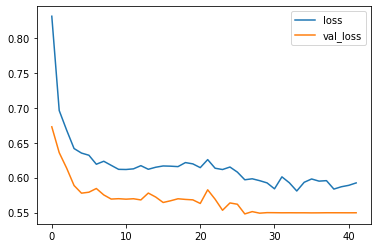

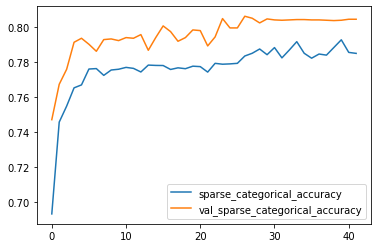

In [44]:
print(model.summary())
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
history_df.loc[:, ['sparse_categorical_accuracy', 'val_sparse_categorical_accuracy']].plot()

In [38]:
#print(model.summary())

In [45]:
#make top few layers in base model trainable, then train on dataset again
#make all layers trainable
for layer in model.layers:
    layer.trainable = True
    
#l2 regularization #https://stackoverflow.com/questions/48330137/adding-regularizer-to-an-existing-layer-of-a-trained-model-without-resetting-wei
l2 = tf.keras.regularizers.l2(1e-4)

#1e-4 works better 1e-5, also seems to work better than 1e-3
# apply just on Conv
for layer in model.layers[1].layers:
    #print(layer)
    if isinstance(layer, tf.keras.layers.Conv2D):
        #model.add_loss(lambda layer: l2(layer.kernel))#dont really know why need layer=layer instead of just layer
        layer.kernel_regularizer = l2
        
    
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_2 (Batch multiple                  21        
_________________________________________________________________
efficientnet-b5 (Model)      (None, 16, 16, 2048)      28513520  
_________________________________________________________________
global_average_pooling2d_2 ( multiple                  0         
_________________________________________________________________
dropout_2 (Dropout)          multiple                  0         
_________________________________________________________________
dense_2 (Dense)              multiple                  10245     
Total params: 28,523,786
Trainable params: 28,351,035
Non-trainable params: 172,751
_________________________________________________________________
None


In [50]:


#define early stopping
early_stop = tf.keras.callbacks.EarlyStopping(
    #monitor = "val_sparse_categorical_accuracy",
    min_delta = 0.001,
    patience = 5,
    restore_best_weights = True,
)

with strategy.scope():
    model.compile(
        optimizer = tf.keras.optimizers.Adam(epsilon = 1e-7),#learning_rate = lr_schedule, epsilon = 1e-7),
        loss = "sparse_categorical_crossentropy", #use categorical_crossentropy if using one-hot encodings
        metrics = ["sparse_categorical_accuracy"]
    )

history2 = model.fit(train_data, 
                     steps_per_epoch=STEPS_PER_EPOCH, 
                     epochs=EPOCHS,
                     callbacks = [lr_schedule1, early_stop], #lr_schedule1 is not a good fit (initial decrease is good, but increasing again is a mistake)
                     #likely should use early stopping too... also reducing the l2 cost seems to make overfitting an increasing issue
                     validation_data=valid_data,
                     validation_steps=VALID_STEPS)
#compare with previous - l2 weight reduced
#model.save('EfficientNetB6_based.h5')

Epoch 1/30
125/125 [==============================] - 98s 781ms/step - sparse_categorical_accuracy: 0.9326 - loss: 0.2017 - val_sparse_categorical_accuracy: 0.8180 - val_loss: 1.0384 - lr: 0.0020
Epoch 2/30
125/125 [==============================] - 79s 629ms/step - sparse_categorical_accuracy: 0.9390 - loss: 0.1709 - val_sparse_categorical_accuracy: 0.8373 - val_loss: 0.7801 - lr: 0.0020
Epoch 3/30
125/125 [==============================] - 76s 606ms/step - sparse_categorical_accuracy: 0.9526 - loss: 0.1391 - val_sparse_categorical_accuracy: 0.8102 - val_loss: 1.2105 - lr: 0.0018
Epoch 4/30
125/125 [==============================] - 79s 630ms/step - sparse_categorical_accuracy: 0.9595 - loss: 0.1188 - val_sparse_categorical_accuracy: 0.8455 - val_loss: 0.7752 - lr: 0.0016
Epoch 5/30
125/125 [==============================] - 76s 607ms/step - sparse_categorical_accuracy: 0.9790 - loss: 0.0647 - val_sparse_categorical_accuracy: 0.8571 - val_loss: 0.7958 - lr: 0.0013
Epoch 6/30
125/125 [

In [53]:
with strategy.scope():
    model.compile(
        optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-5, epsilon = 1e-7),
        loss = "sparse_categorical_crossentropy", #use categorical_crossentropy if using one-hot encodings
        metrics = ["sparse_categorical_accuracy"]
    )

history2_2 = model.fit(train_data, 
                     steps_per_epoch=STEPS_PER_EPOCH, 
                     epochs=EPOCHS,
                     callbacks = [early_stop],
                     validation_data=valid_data,
                     validation_steps=VALID_STEPS)

#model.save('EfficientNetB6_based.h5')

Epoch 1/30
125/125 [==============================] - 99s 795ms/step - sparse_categorical_accuracy: 0.9718 - loss: 0.1307 - val_sparse_categorical_accuracy: 0.9405 - val_loss: 0.3029
Epoch 2/30
125/125 [==============================] - 79s 629ms/step - sparse_categorical_accuracy: 0.9733 - loss: 0.1193 - val_sparse_categorical_accuracy: 0.9415 - val_loss: 0.2879
Epoch 3/30
125/125 [==============================] - 79s 631ms/step - sparse_categorical_accuracy: 0.9730 - loss: 0.1218 - val_sparse_categorical_accuracy: 0.9409 - val_loss: 0.2786
Epoch 4/30
125/125 [==============================] - 79s 630ms/step - sparse_categorical_accuracy: 0.9743 - loss: 0.1111 - val_sparse_categorical_accuracy: 0.9411 - val_loss: 0.2703
Epoch 5/30
125/125 [==============================] - 78s 628ms/step - sparse_categorical_accuracy: 0.9759 - loss: 0.1043 - val_sparse_categorical_accuracy: 0.9419 - val_loss: 0.2657
Epoch 6/30
125/125 [==============================] - 79s 629ms/step - sparse_categor

In [48]:
#redefine early stop
#define early stopping
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor = "val_sparse_categorical_accuracy",
    min_delta = 0.0005,
    patience = 5,
    restore_best_weights = True,
)

with strategy.scope():
    model.compile(
        optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-6, epsilon = 1e-7),
        loss = "sparse_categorical_crossentropy", #use categorical_crossentropy if using one-hot encodings
        metrics = ["sparse_categorical_accuracy"]
    )

history2_3 = model.fit(train_data, 
                     steps_per_epoch=STEPS_PER_EPOCH, 
                     epochs=EPOCHS,
                     callbacks = [early_stop],
                     validation_data=valid_data,
                     validation_steps=VALID_STEPS)

#model.save('EfficientNetB6_based.h5')

Epoch 1/30
125/125 [==============================] - 98s 784ms/step - sparse_categorical_accuracy: 0.9977 - loss: 0.0078 - val_sparse_categorical_accuracy: 0.8807 - val_loss: 0.6951
Epoch 2/30
125/125 [==============================] - 79s 630ms/step - sparse_categorical_accuracy: 0.9983 - loss: 0.0073 - val_sparse_categorical_accuracy: 0.8813 - val_loss: 0.6954
Epoch 3/30
125/125 [==============================] - 75s 604ms/step - sparse_categorical_accuracy: 0.9983 - loss: 0.0067 - val_sparse_categorical_accuracy: 0.8803 - val_loss: 0.6959
Epoch 4/30
125/125 [==============================] - 75s 602ms/step - sparse_categorical_accuracy: 0.9982 - loss: 0.0065 - val_sparse_categorical_accuracy: 0.8803 - val_loss: 0.6980
Epoch 5/30
125/125 [==============================] - 75s 604ms/step - sparse_categorical_accuracy: 0.9983 - loss: 0.0068 - val_sparse_categorical_accuracy: 0.8805 - val_loss: 0.6974
Epoch 6/30
125/125 [==============================] - 75s 604ms/step - sparse_categor

In [49]:
with strategy.scope():
    model.compile(
        optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-7, epsilon = 1e-8),
        loss = "sparse_categorical_crossentropy", #use categorical_crossentropy if using one-hot encodings
        metrics = ["sparse_categorical_accuracy"]
    )

history2_4 = model.fit(train_data, 
                     steps_per_epoch=STEPS_PER_EPOCH, 
                     epochs=EPOCHS,
                     callbacks = [early_stop],
                     validation_data=valid_data,
                     validation_steps=VALID_STEPS)

model.save('EfficientNetB5_based.h5')

Epoch 1/30
125/125 [==============================] - 98s 780ms/step - sparse_categorical_accuracy: 0.9977 - loss: 0.0077 - val_sparse_categorical_accuracy: 0.8822 - val_loss: 0.6977
Epoch 2/30
125/125 [==============================] - 76s 606ms/step - sparse_categorical_accuracy: 0.9979 - loss: 0.0068 - val_sparse_categorical_accuracy: 0.8817 - val_loss: 0.6965
Epoch 3/30
125/125 [==============================] - 76s 605ms/step - sparse_categorical_accuracy: 0.9982 - loss: 0.0066 - val_sparse_categorical_accuracy: 0.8809 - val_loss: 0.6969
Epoch 4/30
125/125 [==============================] - 76s 606ms/step - sparse_categorical_accuracy: 0.9983 - loss: 0.0064 - val_sparse_categorical_accuracy: 0.8815 - val_loss: 0.6962
Epoch 5/30
125/125 [==============================] - 76s 606ms/step - sparse_categorical_accuracy: 0.9986 - loss: 0.0057 - val_sparse_categorical_accuracy: 0.8815 - val_loss: 0.6977
Epoch 6/30
125/125 [==============================] - 80s 642ms/step - sparse_categor

## append new data onto history_df to see full training graph

history_df2 = pd.DataFrame(history2.history)
history_df2.loc[:, ['loss', 'val_loss']].plot()
history_df2.loc[:, ['sparse_categorical_accuracy', 'val_sparse_categorical_accuracy']].plot()

In [ ]:
history_df2.index = range(31,31+len(history_df2.index))

total_history_df = pd.concat([history_df, history_df2])
total_history_df.loc[:, ['loss', 'val_loss']].plot()
total_history_df.loc[:, ['sparse_categorical_accuracy', 'val_sparse_categorical_accuracy']].plot()

In [ ]:
layers = []
for layer in model.layers:
    layers.append(layer)
    print(layer)
#print(layers)

#print(layers[1])
#for layer in layers[1].layers:
#    print(layer)
for layer in model.layers[1].layers:
    print(layer)
    